# Detecting Cyberbullying on Social Media Platforms using BERT

## Custom functions definition:

In [1]:
def conf_matrix(y, y_pred, title, labels):
    fig, ax =plt.subplots(figsize=(7.5,7.5))
    ax=sns.heatmap(confusion_matrix(y, y_pred), annot=True, cmap="Purples", fmt='g', cbar=False, annot_kws={"size":30})
    plt.title(title, fontsize=25)
    ax.xaxis.set_ticklabels(labels, fontsize=16) 
    ax.yaxis.set_ticklabels(labels, fontsize=14.5)
    ax.set_ylabel('Test', fontsize=25)
    ax.set_xlabel('Predicted', fontsize=25)
    plt.show()

In [2]:
#pip install langdetect

In [3]:
#pip install contractions

## Import libraries

In [4]:
# Libraries for general purpose
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Text cleaning
import re
import string
import emoji
import nltk
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import stopwords

# Data preprocessing
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from langdetect import detect, LangDetectException
import contractions
from nltk.tokenize import word_tokenize

# Naive Bayes
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

# PyTorch LSTM
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# Tokenization for LSTM
from collections import Counter
from gensim.models import Word2Vec

# Transformers library for BERT
import transformers
from transformers import BertModel
from transformers import BertTokenizer
from transformers import AdamW, get_linear_schedule_with_warmup
from sklearn.metrics import classification_report, confusion_matrix

import time

# Set seed for reproducibility
import random
seed_value = 2042
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
torch.cuda.manual_seed_all(seed_value)

# Set style for plots
sns.set_style("whitegrid")
sns.despine()

# Remove plt.style.use("seaborn-whitegrid") since it's redundant
plt.rc("figure", autolayout=True)
plt.rc("axes", labelweight="bold", labelsize="large", titleweight="bold", titlepad=10)


# Define stop words for text cleaning
stop_words = set(stopwords.words('english'))

# Initialize lemmatizer for text cleaning
lemmatizer = WordNetLemmatizer()

<Figure size 640x480 with 0 Axes>

## Data Import

In [5]:
df = pd.read_csv("../datasets/CyberbullyingTypesDataset.csv", encoding="iso-8859-1")

In [6]:
df.head()

,Tweet,Class
0,Post-Cuomo push to toughen NY sexual harassmen...,Sexual Harassment
1,Push to toughen NY sexual harassment laws that...,Sexual Harassment
2,@GabbieHanna As if Trisha didnât accuse him ...,Sexual Harassment
3,@fentsemadii True is that ð¥ thou I know not...,Sexual Harassment
4,Watch the recap video of the two-day hands-on ...,Sexual Harassment


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2140 entries, 0 to 2139
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Tweet   2140 non-null   object
 1   Class   2140 non-null   object
dtypes: object(2)
memory usage: 33.6+ KB


First we rename the columns using shorter words for easier reference.

In [8]:
df = df.rename(columns={'Tweet': 'text', 'Class': 'sentiment'})

### Are there duplicated tweets?

In [9]:
df.duplicated().sum()

32

There are some duplicated tweets, we will remove them.

In [10]:
df = df[~df.duplicated()]

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2108 entries, 0 to 2139
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       2108 non-null   object
 1   sentiment  2108 non-null   object
dtypes: object(2)
memory usage: 49.4+ KB


### Are the classes balanced?

In [12]:
df.sentiment.value_counts()

sentiment
Slut Shaming         495
Sexual Harassment    494
Doxing               437
Revenge Porn         382
Cyberstalking        300
Name: count, dtype: int64

The classes look balanced.

# Tweets text deep cleaning

Next, we will define custom functions to clean the texts of the tweets.

In [13]:
# Clean emojis from text
def strip_emoji(text):
    # Ensure the input is a string
    if not isinstance(text, str):
        text = str(text)  # Convert non-strings to string (e.g., float, NaN)
    
    emoji_pattern = re.compile(
        "[\U0001F600-\U0001F64F"  # emoticons
        "\U0001F300-\U0001F5FF"  # symbols & pictographs
        "\U0001F680-\U0001F6FF"  # transport & map symbols
        "\U0001F700-\U0001F77F"  # alchemical symbols
        "\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
        "\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
        "\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
        "\U0001FA00-\U0001FA6F"  # Chess Symbols
        "\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
        "\U00002702-\U000027B0"  # Dingbats
        "\U000024C2-\U0001F251"  # Enclosed characters
        "]+", flags=re.UNICODE)
    
    return emoji_pattern.sub(r'', text)

# Remove punctuations, stopwords, links, mentions, and new line characters
def strip_all_entities(text):
    if not isinstance(text, str):
        text = str(text)  # Convert non-strings to string (e.g., float, NaN)
        
    text = re.sub(r'\r|\n', ' ', text.lower())  # Replace newline and carriage return with space, and convert to lowercase
    text = re.sub(r"(?:\@|https?\://)\S+", "", text)  # Remove links and mentions
    text = re.sub(r'[^\x00-\x7f]', '', text)  # Remove non-ASCII characters
    banned_list = string.punctuation
    table = str.maketrans('', '', banned_list)
    text = text.translate(table)
    text = ' '.join(word for word in text.split() if word not in stop_words)
    return text

# Clean hashtags at the end of the sentence, and keep those in the middle of the sentence by removing just the # symbol
def clean_hashtags(tweet):
    if not isinstance(tweet, str):
        tweet = str(tweet)  # Convert non-strings to string (e.g., float, NaN)
    
    # Remove hashtags at the end of the sentence
    new_tweet = re.sub(r'(\s+#[\w-]+)+\s*$', '', tweet).strip()
    
    # Remove the # symbol from hashtags in the middle of the sentence
    new_tweet = re.sub(r'#([\w-]+)', r'\1', new_tweet).strip()
    
    return new_tweet

# Filter special characters such as & and $ present in some words
def filter_chars(text):
    if not isinstance(text, str):
        text = str(text)  # Convert non-strings to string (e.g., float, NaN)
    return ' '.join('' if ('$' in word) or ('&' in word) else word for word in text.split())

# Remove multiple spaces
def remove_mult_spaces(text):
    if not isinstance(text, str):
        text = str(text)  # Convert non-strings to string (e.g., float, NaN)
    return re.sub(r"\s\s+", " ", text)

# Function to check if the text is in English, and return an empty string if it's not
def filter_non_english(text):
    try:
        lang = detect(text)
    except LangDetectException:
        lang = "unknown"
    return text if lang == "en" else ""

# Expand contractions
def expand_contractions(text):
    if not isinstance(text, str):
        text = str(text)  # Convert non-strings to string (e.g., float, NaN)
    return contractions.fix(text)

# Remove numbers
def remove_numbers(text):
    if not isinstance(text, str):
        text = str(text)  # Convert non-strings to string (e.g., float, NaN)
    return re.sub(r'\d+', '', text)

# Lemmatize words
def lemmatize(text):
    if not isinstance(text, str):
        text = str(text)  # Convert non-strings to string (e.g., float, NaN)
    words = word_tokenize(text)
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(lemmatized_words)

# Remove short words
def remove_short_words(text, min_len=2):
    if not isinstance(text, str):
        text = str(text)  # Convert non-strings to string (e.g., float, NaN)
    words = text.split()
    long_words = [word for word in words if len(word) >= min_len]
    return ' '.join(long_words)

# Replace elongated words with their base form
def replace_elongated_words(text):
    if not isinstance(text, str):
        text = str(text)  # Convert non-strings to string (e.g., float, NaN)
    regex_pattern = r'\b(\w+)((\w)\3{2,})(\w*)\b'
    return re.sub(regex_pattern, r'\1\3\4', text)

# Remove repeated punctuation
def remove_repeated_punctuation(text):
    if not isinstance(text, str):
        text = str(text)  # Convert non-strings to string (e.g., float, NaN)
    return re.sub(r'[\?\.\!]+(?=[\?\.\!])', '', text)

# Remove extra whitespace
def remove_extra_whitespace(text):
    if not isinstance(text, str):
        text = str(text)  # Convert non-strings to string (e.g., float, NaN)
    return ' '.join(text.split())

# Remove URL shorteners
def remove_url_shorteners(text):
    if not isinstance(text, str):
        text = str(text)  # Convert non-strings to string (e.g., float, NaN)
    return re.sub(r'(?:http[s]?://)?(?:www\.)?(?:bit\.ly|goo\.gl|t\.co|tinyurl\.com|tr\.im|is\.gd|cli\.gs|u\.nu|url\.ie|tiny\.cc|alturl\.com|ow\.ly|bit\.do|adoro\.to)\S+', '', text)

# Remove spaces at the beginning and end of the tweet
def remove_spaces_tweets(tweet):
    if not isinstance(tweet, str):
        tweet = str(tweet)  # Convert non-strings to string (e.g., float, NaN)
    return tweet.strip()

# Remove short tweets
def remove_short_tweets(tweet, min_words=3):
    if not isinstance(tweet, str):
        tweet = str(tweet)  # Convert non-strings to string (e.g., float, NaN)
    words = tweet.split()
    return tweet if len(words) >= min_words else ""

# Function to call all the cleaning functions in the correct order
def clean_tweet(tweet):
    if not isinstance(tweet, str):
        tweet = str(tweet)  # Ensure tweet is a string
    
    tweet = strip_emoji(tweet)
    tweet = expand_contractions(tweet)
    tweet = filter_non_english(tweet)
    tweet = strip_all_entities(tweet)
    tweet = clean_hashtags(tweet)
    tweet = filter_chars(tweet)
    tweet = remove_mult_spaces(tweet)
    tweet = remove_numbers(tweet)
    tweet = lemmatize(tweet)
    tweet = remove_short_words(tweet)
    tweet = replace_elongated_words(tweet)
    tweet = remove_repeated_punctuation(tweet)
    tweet = remove_extra_whitespace(tweet)
    tweet = remove_url_shorteners(tweet)
    tweet = remove_spaces_tweets(tweet)
    tweet = remove_short_tweets(tweet)
    tweet = ' '.join(tweet.split())  # Remove multiple spaces between words
    return tweet


In [15]:
df['text_clean'] = [clean_tweet(tweet) for tweet in df['text']]

In [16]:
df.head()

,text,sentiment,text_clean
0,Post-Cuomo push to toughen NY sexual harassmen...,Sexual Harassment,postcuomo push toughen ny sexual harassmentlaws
1,Push to toughen NY sexual harassment laws that...,Sexual Harassment,push toughen ny sexual harassment law gov cuom...
2,@GabbieHanna As if Trisha didnât accuse him ...,Sexual Harassment,trisha didnt accuse sexual harassment hadnt tr...
3,@fentsemadii True is that ð¥ thou I know not...,Sexual Harassment,true thou know nothing sexual harassment
4,Watch the recap video of the two-day hands-on ...,Sexual Harassment,watch recap video twoday handson executive wor...


### Are there duplicate tweets after the cleaning?

In [17]:
print(f'There are around {int(df["text_clean"].duplicated().sum())} duplicated tweets, we will remove them.')

There are around 294 duplicated tweets, we will remove them.


In [18]:
df.drop_duplicates("text_clean", inplace=True)

We removed the duplicated cleaned tweets. How is the class balance after the cleaning?

In [19]:
df.sentiment.value_counts()

sentiment
Slut Shaming         449
Sexual Harassment    387
Doxing               369
Revenge Porn         349
Cyberstalking        260
Name: count, dtype: int64

We can see that lots of tweets of the class "other_cyberbullying" have been removed. Since the class is very unbalanced compared to the other classes and looks too "generic", we decide to remove the tweets labeled belonging to this class.<br>
EDIT: by performing some tests, the f1 score for predicting the "other_cyberbullying" resulted to be around 60%, a value far lower compared to the othter f1 scores (around 95% using LSTM model). This supports the decision of removing this generic class.

In [20]:
#df = df[df["sentiment"]!="other_cyberbullying"]

Then we also define a list of the classes names, which will be useful for the future plots.

In [21]:
sentiment = ["Cyberstalking", "Revenge Porn", "Doxing", "Sexual Harassment", "Slut Shaming"]

# Tweets length analysis

Now we will define a new dataframe column containing the length of the cleaned tweets in terms of number of words.

In [22]:
df['text_len'] = [len(text.split()) for text in df.text_clean]

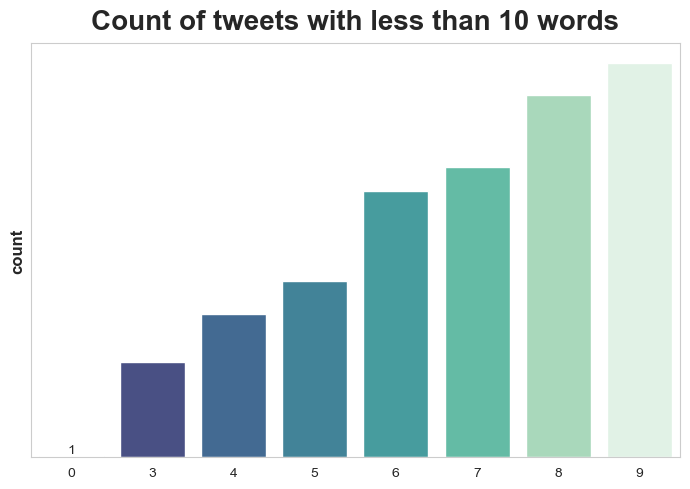

In [23]:
plt.figure(figsize=(7,5))
ax = sns.countplot(x='text_len', data=df[df['text_len']<10], hue='text_len', palette='mako', legend=False)
plt.title('Count of tweets with less than 10 words', fontsize=20)
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show()

### What about long tweets?

In [24]:
df.sort_values(by=['text_len'], ascending=False)

,text,sentiment,text_clean,text_len
395,#CBI files FIR against former CM Oommen Chandy...,Sexual Harassment,cbi file fir former cm oommen chandy aicc gene...,17
1484,This guy \nNo job\nLives with mommy \nPOS\nNo ...,Revenge Porn,guy job life mommy po lady need diet post ex r...,16
1064,@ThatUmbrella Eve Barlow: DOXING WOMEN IS BAD!...,Doxing,eve barlow doxing woman bad also eve barlow ti...,16
440,Luau Party partying hard at 10 on January 18th...,Sexual Harassment,luau party partying hard january th female wel...,16
39,Today: New York State Governor Andrew Cuomo an...,Sexual Harassment,today new york state governor andrew cuomo ann...,16
...,...,...,...,...
145,"Sexual harassment!? S, sorry?",Sexual Harassment,sexual harassment sorry,3
1419,@yorkshiregirl91 @stephen__bear @Jessica_Smith...,Revenge Porn,international playboy international,3
1025,@ApartmentBoss Better than doxing the cia,Doxing,better doxing cia,3
952,@Ingajinga2020 @wilderfortruth @crow32352 They...,Doxing,doxing tucker carlson,3


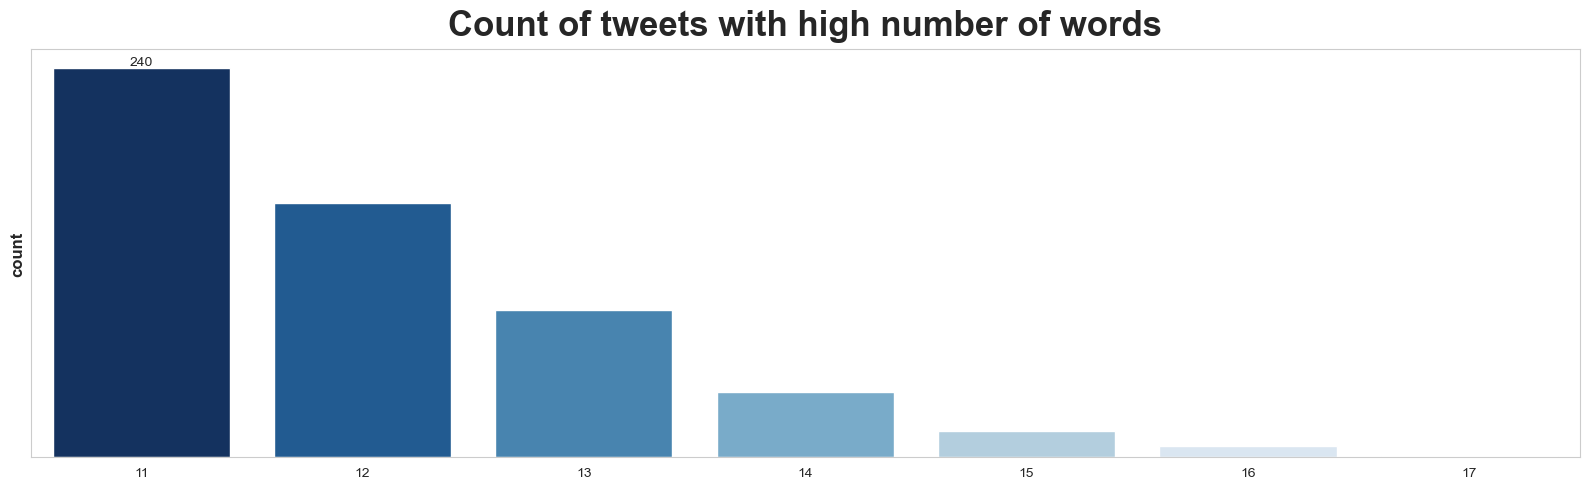

In [25]:
plt.figure(figsize=(16,5))
ax = sns.countplot(x='text_len', data=df[(df['text_len']<=1000) & (df['text_len']>10)],
                   hue='text_len', palette='Blues_r', legend=False)
plt.title('Count of tweets with high number of words', fontsize=25)
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show()

We also will remove tweets that are too long (with more than 100 words).

In [26]:
df = df[df['text_len'] < df['text_len'].quantile(0.995)]

Then we also get the length of the longest tweet since it will be useful later.

In [27]:
max_len = np.max(df['text_len'])
max_len 

14

In [28]:
df.sort_values(by=["text_len"], ascending=False)

,text,sentiment,text_clean,text_len
1275,"""People believed Taylorâs lies that I stole ...",Revenge Porn,people believed taylor lie stole client leaked...,14
710,"Yep! Dana, Paula, Marylin, Kelly, etc. are all...",Cyberstalking,yep dana paula marylin kelly etc going jail co...,14
1775,Yes I love this year's big brother all these i...,Slut Shaming,yes love year big brother issue happen everyon...,14
1146,Come on by and have some fun in the Tg &amp; V...,Doxing,come fun tg amp vc doxing poll team member dev...,14
240,The casual nature of sexual harassment in this...,Sexual Harassment,casual nature sexual harassment country sicken...,14
...,...,...,...,...
1791,not my lola slut-shaming my catð­âð»âð»,Slut Shaming,lola slutshaming cat,3
1195,@WallStreetJane @SummitCountySO Doxing is ille...,Doxing,doxing illegal jane,3
145,"Sexual harassment!? S, sorry?",Sexual Harassment,sexual harassment sorry,3
944,This guy needs doxingâ¦ https://t.co/bMEPotN2W8,Doxing,guy need doxing,3


## Sentiment column encoding

The target column will be encoded by ordinal encoding

In [29]:
df['sentiment'] = df['sentiment'].replace({'Cyberstalking':0, 'Revenge Porn':1, 'Doxing':2, 'Sexual Harassment':3, 'Slut Shaming':4})

C:\Users\USTB\AppData\Local\Temp\ipykernel_15036\3582277428.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['sentiment'] = df['sentiment'].replace({'Cyberstalking':0, 'Revenge Porn':1, 'Doxing':2, 'Sexual Harassment':3, 'Slut Shaming':4})
C:\Users\USTB\AppData\Local\Temp\ipykernel_15036\3582277428.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sentiment'] = df['sentiment'].replace({'Cyberstalking':0, 'Revenge Porn':1, 'Doxing':2, 'Sexual Harassment':3, 'Slut Shaming':4})


## Train - Test split

Now we need to split the dataset into a train and test sets.

In [30]:
X = df['text_clean']
y = df['sentiment']

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=seed_value)

## Train - Validation split

Moreover, we will further split the training set to extract a validation set, which will be used to monior the accuracy and loss to avoid overfitting during the model training.

In [32]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=seed_value)

In [33]:
(unique, counts) = np.unique(y_train, return_counts=True)
np.asarray((unique, counts)).T

array([[  0, 165],
       [  1, 221],
       [  2, 235],
       [  3, 239],
       [  4, 285]], dtype=int64)

The classes are unbalanced, so it could be a good idea to oversample the training set such that all classes have the same count as the most populated one.

# Oversampling of training set

In [34]:
ros = RandomOverSampler()
X_train, y_train = ros.fit_resample(np.array(X_train).reshape(-1, 1), np.array(y_train).reshape(-1, 1));
train_os = pd.DataFrame(list(zip([x[0] for x in X_train], y_train)), columns = ['text_clean', 'sentiment']);

In [35]:
X_train = train_os['text_clean'].values
y_train = train_os['sentiment'].values

In [36]:
(unique, counts) = np.unique(y_train, return_counts=True)
np.asarray((unique, counts)).T

array([[  0, 285],
       [  1, 285],
       [  2, 285],
       [  3, 285],
       [  4, 285]], dtype=int64)

# BERT Classification

In this section, we will load a pre trained BERT model from the Hugging Face library and fine tune it for our classification task.

First, we need to split the dataset into train - validation - test again since we need to tokenize the sentences differently from before (Naive Bayes and LSTM).

## Train - Validation - Test split

In [37]:
X = df['text_clean'].values
y = df['sentiment'].values

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=seed_value)

In [39]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=seed_value)

As seen before, we oversample the text to the majority class.

In [40]:
ros = RandomOverSampler()
X_train_os, y_train_os = ros.fit_resample(np.array(X_train).reshape(-1,1),np.array(y_train).reshape(-1,1))

In [41]:
X_train_os = X_train_os.flatten()
y_train_os = y_train_os.flatten()

In [42]:
(unique, counts) = np.unique(y_train_os, return_counts=True)
np.asarray((unique, counts)).T

array([[  0, 285],
       [  1, 285],
       [  2, 285],
       [  3, 285],
       [  4, 285]], dtype=int64)

# BERT Tokenization

Since we need to tokenize the tweets (get "input ids" and "attention masks") for BERT, we load the specific BERT tokenizer from the Hugging Face library.

In [43]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Then we define a custom tokenizer function using the loaded tokenizer.

In [44]:
def bert_tokenizer(data):
    input_ids = []
    attention_masks = []
    for sent in data:
        encoded_sent = tokenizer.encode_plus(
            text=sent,
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]` special tokens
            max_length=MAX_LEN,             # Choose max length to truncate/pad
            pad_to_max_length=True,         # Pad sentence to max length 
            return_attention_mask=True      # Return attention mask
            )
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks

Since we need to specify the length of the longest tokenized sentence, we tokenize the train tweets using the "encode" method of the original BERT tokenizer and check the longest sentence.

In [45]:
# Tokenize train tweets
encoded_tweets = [tokenizer.encode(sent, add_special_tokens=True) for sent in X_train]

# Find the longest tokenized tweet
max_len = max([len(sent) for sent in encoded_tweets])
print('Max length: ', max_len)

Max length:  28


We can choose the max length as 128.

In [46]:
MAX_LEN = 128

Then we can tokenize the train, validation and test tweets using the custom define tokenizer.

In [47]:
train_inputs, train_masks = bert_tokenizer(X_train_os)
val_inputs, val_masks = bert_tokenizer(X_valid)
test_inputs, test_masks = bert_tokenizer(X_test)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
C:\Users\USTB\anaconda3\Lib\site-packages\transformers\tokenization_utils_base.py:2834: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


## Data preprocessing for BERT model

Since we are using the BERT model built, we need to convert the arrays to tensors and create dataloaders for the data.

In [48]:
# Convert target columns to pytorch tensors format
train_labels = torch.from_numpy(y_train_os)
val_labels = torch.from_numpy(y_valid)
test_labels = torch.from_numpy(y_test)

## Dataloaders

To fine-tune the BERT model, the original authors recommend a batch size of 16 or 32.

In [49]:
batch_size = 32

In [50]:
# Create the DataLoader for our training set
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set
val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

# Create the DataLoader for our test set
test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

# BERT Modeling

Now we can create a custom BERT classifier class, including the original BERT model (made of transformer layers) and additional Dense layers to perform the desired classification task.

In [51]:
class Bert_Classifier(nn.Module):
    def __init__(self, freeze_bert=False):
        super(Bert_Classifier, self).__init__()
        # Specify hidden size of BERT, hidden size of the classifier, and number of labels
        n_input = 768
        n_hidden = 50
        n_output = 5

        # Instantiate BERT model
        self.bert = BertModel.from_pretrained('bert-base-uncased')

        # Instantiate the classifier (a fully connected layer followed by a ReLU activation and another fully connected layer)
        self.classifier = nn.Sequential(
            nn.Linear(n_input, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_output)
        )

        # Freeze the BERT model weights if freeze_bert is True (useful for feature extraction without fine-tuning)
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False

    def forward(self, input_ids, attention_mask):
        # Feed input data (input_ids and attention_mask) to BERT
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)

        # Extract the last hidden state of the `[CLS]` token from the BERT output (useful for classification tasks)
        last_hidden_state_cls = outputs[0][:, 0, :]

        # Feed the extracted hidden state to the classifier to compute logits
        logits = self.classifier(last_hidden_state_cls)

        return logits

Moreover, since we want to define a learning rate scheduler, we define a custom "initalize_model" function as follows.

In [52]:
# Function for initializing the BERT Classifier model, optimizer, and learning rate scheduler
def initialize_model(epochs=4):
    # Instantiate Bert Classifier
    bert_classifier = Bert_Classifier(freeze_bert=False)

    bert_classifier.to(device)

    # Set up optimizer
    optimizer = AdamW(bert_classifier.parameters(),
                      lr=5e-5,    # learning rate, set to default value
                      eps=1e-8    # decay, set to default value
                      )

    # Calculate total number of training steps
    total_steps = len(train_dataloader) * epochs

    # Define the learning rate scheduler
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0, # Default value
                                                num_training_steps=total_steps)
    return bert_classifier, optimizer, scheduler

We also specify the use of GPU if present (highly recommended for the fine tuning)

In [53]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
EPOCHS=2

And then we intialize the BERT model calling the "initialize_model" function we defined.

In [54]:
bert_classifier, optimizer, scheduler = initialize_model(epochs=EPOCHS)

C:\Users\USTB\anaconda3\Lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


# BERT Training

After defining the custom BERT classifier model, we are ready to start the training.

In [55]:
# Define Cross entropy Loss function for the multiclass classification task
loss_fn = nn.CrossEntropyLoss()

def bert_train(model, train_dataloader, val_dataloader=None, epochs=4, evaluation=False):

    print("Start training...\n")
    for epoch_i in range(epochs):
        print("-"*10)
        print("Epoch : {}".format(epoch_i+1))
        print("-"*10)
        print("-"*38)
        print(f"{'BATCH NO.':^7} | {'TRAIN LOSS':^12} | {'ELAPSED (s)':^9}")
        print("-"*38)

        # Measure the elapsed time of each epoch
        t0_epoch, t0_batch = time.time(), time.time()

        # Reset tracking variables at the beginning of each epoch
        total_loss, batch_loss, batch_counts = 0, 0, 0
        
        ###TRAINING###

        # Put the model into the training mode
        model.train()

        for step, batch in enumerate(train_dataloader):
            batch_counts +=1
            
            b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

            # Zero out any previously calculated gradients
            model.zero_grad()

            # Perform a forward pass and get logits.
            logits = model(b_input_ids, b_attn_mask)

            # Compute loss and accumulate the loss values
            loss = loss_fn(logits, b_labels)
            batch_loss += loss.item()
            total_loss += loss.item()

            # Perform a backward pass to calculate gradients
            loss.backward()

            # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update model parameters:
            # fine tune BERT params and train additional dense layers
            optimizer.step()
            # update learning rate
            scheduler.step()

            # Print the loss values and time elapsed for every 100 batches
            if (step % 100 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                # Calculate time elapsed for 20 batches
                time_elapsed = time.time() - t0_batch
                
                print(f"{step:^9} | {batch_loss / batch_counts:^12.6f} | {time_elapsed:^9.2f}")

                # Reset batch tracking variables
                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()

        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)

        ###EVALUATION###
        
        # Put the model into the evaluation mode
        model.eval()
        
        # Define empty lists to host accuracy and validation for each batch
        val_accuracy = []
        val_loss = []

        for batch in val_dataloader:
            batch_input_ids, batch_attention_mask, batch_labels = tuple(t.to(device) for t in batch)
            
            # We do not want to update the params during the evaluation,
            # So we specify that we dont want to compute the gradients of the tensors
            # by calling the torch.no_grad() method
            with torch.no_grad():
                logits = model(batch_input_ids, batch_attention_mask)

            loss = loss_fn(logits, batch_labels)

            val_loss.append(loss.item())

            # Get the predictions starting from the logits (get index of highest logit)
            preds = torch.argmax(logits, dim=1).flatten()

            # Calculate the validation accuracy 
            accuracy = (preds == batch_labels).cpu().numpy().mean() * 100
            val_accuracy.append(accuracy)

        # Compute the average accuracy and loss over the validation set
        val_loss = np.mean(val_loss)
        val_accuracy = np.mean(val_accuracy)
        
        # Print performance over the entire training data
        time_elapsed = time.time() - t0_epoch
        print("-"*61)
        print(f"{'AVG TRAIN LOSS':^12} | {'VAL LOSS':^10} | {'VAL ACCURACY (%)':^9} | {'ELAPSED (s)':^9}")
        print("-"*61)
        print(f"{avg_train_loss:^14.6f} | {val_loss:^10.6f} | {val_accuracy:^17.2f} | {time_elapsed:^9.2f}")
        print("-"*61)
        print("\n")
    
    print("Training complete!")

In [56]:
bert_train(bert_classifier, train_dataloader, val_dataloader, epochs=EPOCHS)

Start training...

----------
Epoch : 1
----------
--------------------------------------
BATCH NO. |  TRAIN LOSS  | ELAPSED (s)
--------------------------------------
   44     |   1.067286   |  134.63  
-------------------------------------------------------------
AVG TRAIN LOSS |  VAL LOSS  | VAL ACCURACY (%) | ELAPSED (s)
-------------------------------------------------------------
   1.067286    |  0.642316  |       80.16       |  149.68  
-------------------------------------------------------------


----------
Epoch : 2
----------
--------------------------------------
BATCH NO. |  TRAIN LOSS  | ELAPSED (s)
--------------------------------------
   44     |   0.448275   |  134.85  
-------------------------------------------------------------
AVG TRAIN LOSS |  VAL LOSS  | VAL ACCURACY (%) | ELAPSED (s)
-------------------------------------------------------------
   0.448275    |  0.586594  |       80.86       |  150.53  
-------------------------------------------------------

# BERT Prediction

Now we define a function similar to the model "evaluation", where we feed to the model the test data instead of the validation data.

In [57]:
import time
import psutil
from sklearn.metrics import accuracy_score
from codecarbon import EmissionsTracker
import torch

def bert_predict(model, test_dataloader, true_labels, device):
    # Initialize the emissions tracker to monitor energy consumption
    tracker = EmissionsTracker()
    tracker.start()

    # Define an empty list to host the predictions
    preds_list = []
    
    # Put the model into evaluation mode
    model.eval()

    # Measure initial memory usage
    process = psutil.Process()
    initial_memory = process.memory_info().rss / (1024 * 1024)  # Convert to MB

    # Start measuring inference time
    start_time = time.time()  # Start the timer

    # Loop through the batches in the dataloader
    for batch in test_dataloader:
        batch_input_ids, batch_attention_mask = tuple(t.to(device) for t in batch)[:2]
        
        # Avoid gradient calculation of tensors by using "no_grad()" method
        with torch.no_grad():
            logit = model(batch_input_ids, batch_attention_mask)
        
        # Get the index of the highest logit
        pred = torch.argmax(logit, dim=1).cpu().numpy()
        
        # Append predicted class to list
        preds_list.extend(pred)

    # End measuring inference time
    end_time = time.time()  # End the timer

    # Calculate total inference time
    inference_time = end_time - start_time

    # Measure final memory usage
    final_memory = process.memory_info().rss / (1024 * 1024)  # Convert to MB
    memory_usage = final_memory - initial_memory  # In MB

    # Assuming CPU usage as a proxy for energy consumption
    cpu_usage = psutil.cpu_percent(interval=inference_time)

    # Stop the emissions tracker and get energy consumption in kWh
    emissions = tracker.stop()

    # Calculate accuracy
    accuracy = accuracy_score(true_labels, preds_list)

    # Calculate error rate
    error_rate = 1 - accuracy

    # Print all the metrics
    print(f"Inference Time: {inference_time:.4f} seconds")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Error Rate: {error_rate:.4f}")
    print(f"Memory Usage: {memory_usage:.2f} MB")
    print(f"CPU Usage during Inference: {cpu_usage:.2f}%")
    print(f"Energy Consumption: {emissions} kWh")

    return preds_list

Then we can call the defined function and get the class predictions of the test data.

In [58]:
# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Extract true labels from the dataloader
true_labels = []
for batch in test_dataloader:
    labels = batch[2].to(device).cpu().numpy()  # Ensure labels are moved to the CPU if on GPU
    true_labels.extend(labels)

# Make predictions
bert_preds = bert_predict(bert_classifier, test_dataloader, true_labels, device)

[codecarbon INFO @ 03:48:04] [setup] RAM Tracking...
[codecarbon INFO @ 03:48:04] [setup] GPU Tracking...
[codecarbon INFO @ 03:48:04] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 03:48:04] [setup] CPU Tracking...
[codecarbon WARNING @ 03:48:04] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon WARNING @ 03:48:05] We saw that you have a 13th Gen Intel(R) Core(TM) i9-13900 but we don't know it. Please contact us.
[codecarbon INFO @ 03:48:05] CPU Model on constant consumption mode: 13th Gen Intel(R) Core(TM) i9-13900
[codecarbon INFO @ 03:48:05] >>> Tracker's metadata:
[codecarbon INFO @ 03:48:05]   Platform system: Windows-10-10.0.22631-SP0
[codecarbon INFO @ 03:48:05]   Python version: 3.11.5
[codecarbon INFO @ 03:48:05]   CodeCarbon version: 2.2.2
[codecarbon INFO @ 03:48:05]   Available RAM : 31.696 GB
[codecarbon INFO @ 03:48:05]   CPU count: 32
[codecarbon INFO @ 03:48:05]   CPU model: 13th Gen Intel(R) Core(TM) i9-13900
[codecarbon INFO @ 03:48:05]   

Inference Time: 31.2254 seconds
Accuracy: 0.8547
Error Rate: 0.1453
Memory Usage: -96.38 MB
CPU Usage during Inference: 0.40%
Energy Consumption: 2.0484785291344588e-05 kWh


In [59]:
# Print classification report
print('Classification Report for BERT:\n', classification_report(y_test, bert_preds, target_names=sentiment))

Classification Report for BERT:
                    precision    recall  f1-score   support

    Cyberstalking       0.83      0.75      0.79        52
     Revenge Porn       0.81      0.83      0.82        69
           Doxing       0.87      0.84      0.85        73
Sexual Harassment       0.86      0.87      0.86        75
     Slut Shaming       0.88      0.94      0.91        89

         accuracy                           0.85       358
        macro avg       0.85      0.84      0.85       358
     weighted avg       0.85      0.85      0.85       358



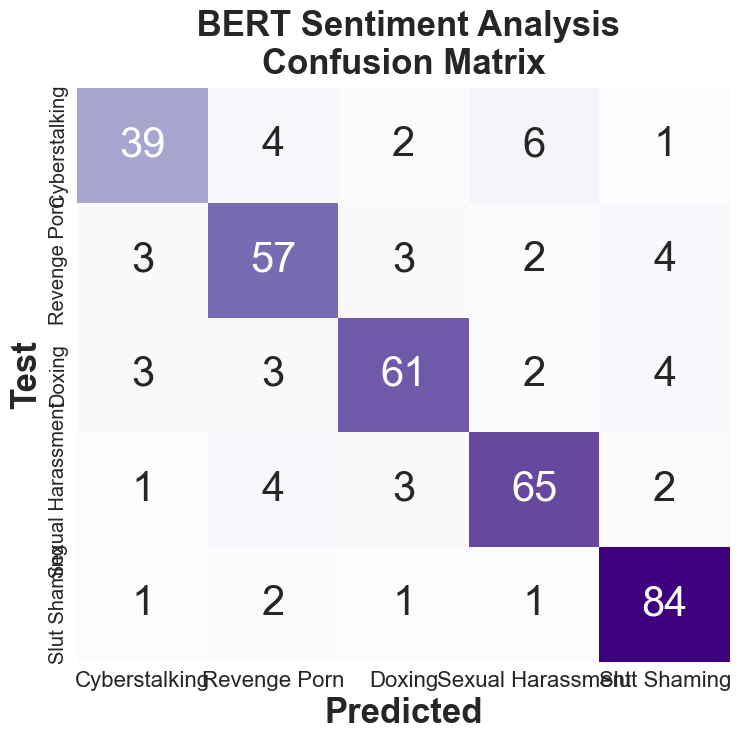

In [60]:
conf_matrix(y_test, bert_preds,' BERT Sentiment Analysis\nConfusion Matrix', sentiment)

**The performance scores of BERT Classifier are quite high and higher than those achieved using the LSTM model, with an overall accuracy around 95% and F1 scores well over 95%.**<br>

Thank your for checking out my notebook! Let me know if you have comments or if you want me to check out your work! :)